**Eric Meinhardt / emeinhardt@ucsd.edu**

In [1]:
#Prints **all** console output, not just last item in cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import csv

In [3]:
from collections import Counter

In [4]:
# used only in the 'exclusion criteria' section; not essential
import pandas as pd
from plotnine import *
from math import log, e

In [5]:
from random import choice

In [6]:
from functools import reduce
from itertools import takewhile, product

# from boilerplate import *
import re
# from more_itertools import replace
# from funcy import compose

In [7]:
from joblib import Parallel, delayed

J = 10
BACKEND = 'multiprocessing'
# BACKEND = 'loky'
V = 10
PREFER = 'processes'
# PREFER = 'threads'

def par(gen_expr):
    return Parallel(n_jobs=J, backend=BACKEND, verbose=V, prefer=PREFER)(gen_expr)

def identity(x):
    return x

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview-&amp;-Dependencies" data-toc-modified-id="Overview-&amp;-Dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview &amp; Dependencies</a></span></li><li><span><a href="#Reading-in-the-data" data-toc-modified-id="Reading-in-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reading in the data</a></span><ul class="toc-item"><li><span><a href="#CMU-pronouncing-dictionary" data-toc-modified-id="CMU-pronouncing-dictionary-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>CMU pronouncing dictionary</a></span></li><li><span><a href="#Unigram-counts-from-COCA" data-toc-modified-id="Unigram-counts-from-COCA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Unigram counts from COCA</a></span></li></ul></li><li><span><a href="#Align-(take-the-natural-join)-of-the-word-frequency-relation-and-the-pronunciation-relation" data-toc-modified-id="Align-(take-the-natural-join)-of-the-word-frequency-relation-and-the-pronunciation-relation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Align (take the natural join) of the word frequency relation and the pronunciation relation</a></span><ul class="toc-item"><li><span><a href="#Lowercase-the-CMU-dictionary's-orthographic-words" data-toc-modified-id="Lowercase-the-CMU-dictionary's-orthographic-words-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Lowercase the CMU dictionary's orthographic words</a></span></li><li><span><a href="#Filter-out-entries-that-don't-have-a-frequency-count" data-toc-modified-id="Filter-out-entries-that-don't-have-a-frequency-count-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Filter out entries that don't have a frequency count</a></span></li><li><span><a href="#Add-counts" data-toc-modified-id="Add-counts-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Add counts</a></span></li></ul></li><li><span><a href="#Exclusion-criteria" data-toc-modified-id="Exclusion-criteria-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exclusion criteria</a></span><ul class="toc-item"><li><span><a href="#Filter-out-wordforms-below-some-threshold-of-counts-/-take-the-$n$-most-common" data-toc-modified-id="Filter-out-wordforms-below-some-threshold-of-counts-/-take-the-$n$-most-common-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Filter out wordforms below some threshold of counts / take the $n$ most common</a></span></li></ul></li><li><span><a href="#Applying-the-flapping-rule-/-creating-surface-forms" data-toc-modified-id="Applying-the-flapping-rule-/-creating-surface-forms-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Applying the flapping rule / creating surface forms</a></span><ul class="toc-item"><li><span><a href="#Functions-for-manipulating-transcriptions" data-toc-modified-id="Functions-for-manipulating-transcriptions-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Functions for manipulating transcriptions</a></span></li><li><span><a href="#Carving-up-the-inventory-and-defining-symbol-classes" data-toc-modified-id="Carving-up-the-inventory-and-defining-symbol-classes-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Carving up the inventory and defining symbol classes</a></span></li><li><span><a href="#Applying-the-flapping-rule" data-toc-modified-id="Applying-the-flapping-rule-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Applying the flapping rule</a></span></li><li><span><a href="#Creating-a-list-of-positive-input-output-examples" data-toc-modified-id="Creating-a-list-of-positive-input-output-examples-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Creating a list of positive input-output examples</a></span></li></ul></li></ul></div>

# Overview & Dependencies

The goal of this notebook is processing the CMU pronouncing dictionary to create data for learning the flapping rule of Gildea & Jurafsky (1996).

 - **Transcriptions:** The version of the CMU pronouncing dictionary processed here is taken from https://github.com/emeinhardt/cmu-ipa.
 - **Frequencies:** For (optional) exclusion criteria, COCA case-insensitive unigram counts are assumed to be in the project directory.
 - **`Unix`-like OS:** Some Unix-like shell commands are used throughout, though they aren't essential.

# Reading in the data

In [8]:
import os
import csv

## CMU pronouncing dictionary

In [9]:
os.getcwd()
root_dir = os.getcwd()

'/mnt/cube/home/AD/emeinhar/gj-flap-data'

In [10]:
os.listdir()

['Recreating the Gildea & Jurafsky (1996) Flapping Data.ipynb',
 '__pycache__',
 '.ipynb_checkpoints',
 '.gitignore',
 'COCA',
 'boilerplate.py',
 '.git',
 'cmudict-0.7b_IPA_stressed.tsv']

In [11]:
%cat -n cmudict-0.7b_IPA_stressed.tsv | head -60





























































cat: write error: Broken pipe


In [12]:
cmudict_filename = 'cmudict-0.7b_IPA_stressed.tsv'

In [13]:
lexicon_relation = []
with open(cmudict_filename, 'r',) as csvfile:
        reader = csv.DictReader(csvfile, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            lexicon_relation.append(row)

In [14]:
lexicon_relation[:5]

[OrderedDict([('Orthography', '!EXCLAMATION-POINT'),
              ('Transcription', 'ɛ2.k.s.k.l.ʌ0.m.eɪ1.ʃ.ʌ0.n.p.ɔɪ2.n.t')]),
 OrderedDict([('Orthography', '"CLOSE-QUOTE'),
              ('Transcription', 'k.l.oʊ1.z.k.w.oʊ1.t')]),
 OrderedDict([('Orthography', '"DOUBLE-QUOTE'),
              ('Transcription', 'd.ʌ1.b.ʌ0.l.k.w.oʊ1.t')]),
 OrderedDict([('Orthography', '"END-OF-QUOTE'),
              ('Transcription', 'ɛ1.n.d.ʌ0.v.k.w.oʊ1.t')]),
 OrderedDict([('Orthography', '"END-QUOTE'),
              ('Transcription', 'ɛ1.n.d.k.w.oʊ1.t')])]

## Unigram counts from COCA

In [15]:
os.getcwd()
os.listdir()

'/mnt/cube/home/AD/emeinhar/gj-flap-data'

['Recreating the Gildea & Jurafsky (1996) Flapping Data.ipynb',
 '__pycache__',
 '.ipynb_checkpoints',
 '.gitignore',
 'COCA',
 'boilerplate.py',
 '.git',
 'cmudict-0.7b_IPA_stressed.tsv']

In [16]:
os.listdir('./COCA')
os.listdir('./COCA/1-gram')

['README', '1-gram']

['w1cs_c.txt', 'w1.txt', 'w1cs.txt']

In [17]:
%cat -n ./COCA/1-gram/w1.txt | head -30































cat: write error: Broken pipe


In [18]:
coca_unigram_fp = os.path.join(root_dir, 'COCA/1-gram/w1.txt')
coca_unigram_fp

'/mnt/cube/home/AD/emeinhar/gj-flap-data/COCA/1-gram/w1.txt'

In [19]:
coca_unigram_raw = []
with open(coca_unigram_fp, 'r') as the_file:
    for row in the_file:
        coca_unigram_raw.append(row.rstrip('\n'))#(row.rstrip('\r\n'))
len(coca_unigram_raw)
coca_unigram_raw[:15]
coca_unigram_raw = coca_unigram_raw[14:]

486702

['Single words occurring three times or more in the',
 'Corpus of Contemporary American English (http://corpus.byu.edu/coca)',
 'Not case sensitive; no part of speech',
 '',
 '',
 'For more information on full word frequency and n-grams lists, see:',
 'http://www.wordfrequency.info',
 'http://www.ngrams.info',
 '',
 '',
 'freq\tword1\t',
 '-----\t-----',
 '',
 '',
 '9738579\ta']

In [20]:
coca_unigram_pairs = list(map(lambda row_string:tuple(row_string.split('\t')),
                              coca_unigram_raw))
coca_unigram_pairs[:5]

[('9738579', 'a'),
 ('40', 'a&e'),
 ('3', 'a&j'),
 ('395', 'a&m'),
 ('7', 'a&m-commerce')]

In [21]:
coca_unigrams = list(map(lambda pair: {'Frequency':int(pair[0]),
                                       'Orthographic_Wordform':pair[1]},
                         coca_unigram_pairs))
coca_unigrams[:5]

[{'Frequency': 9738579, 'Orthographic_Wordform': 'a'},
 {'Frequency': 40, 'Orthographic_Wordform': 'a&e'},
 {'Frequency': 3, 'Orthographic_Wordform': 'a&j'},
 {'Frequency': 395, 'Orthographic_Wordform': 'a&m'},
 {'Frequency': 7, 'Orthographic_Wordform': 'a&m-commerce'}]

In [22]:
coca_freqs = {pair['Orthographic_Wordform']:pair['Frequency'] for pair in coca_unigrams}

In [23]:
coca_freqs = Counter(coca_freqs)

In [24]:
len(coca_freqs)
coca_freqs.most_common(50)

486649

[('the', 23801396),
 ('and', 11675497),
 ('of', 11337574),
 ('to', 11079197),
 ('a', 9738579),
 ('in', 7925095),
 ('that', 5612400),
 ('i', 4500166),
 ('it', 4211033),
 ('is', 4014524),
 ('for', 3713669),
 ('you', 3351609),
 ('was', 3191086),
 ('he', 3139332),
 ('on', 2961975),
 ('with', 2912562),
 ('as', 2603330),
 ('at', 2144984),
 ('this', 2055270),
 ('they', 2015817),
 ('be', 2008109),
 ('are', 1992927),
 ('have', 1982922),
 ('we', 1974304),
 ('but', 1970555),
 ('his', 1964972),
 ('from', 1785694),
 ('not', 1784616),
 ("n't", 1744284),
 ('by', 1643884),
 ('she', 1609139),
 ('or', 1489545),
 ('her', 1486158),
 ('do', 1435121),
 ('had', 1422589),
 ('an', 1412347),
 ('what', 1284606),
 ('one', 1231836),
 ('there', 1207550),
 ('about', 1179399),
 ('were', 1171701),
 ('their', 1170326),
 ('all', 1160709),
 ('has', 1130763),
 ('who', 1107784),
 ('so', 1044305),
 ('said', 1038934),
 ('when', 1028347),
 ('more', 1019247),
 ('if', 1012708)]

# Align (take the natural join) of the word frequency relation and the pronunciation relation

## Lowercase the CMU dictionary's orthographic words

In [25]:
lexicon_relation[0]

OrderedDict([('Orthography', '!EXCLAMATION-POINT'),
             ('Transcription', 'ɛ2.k.s.k.l.ʌ0.m.eɪ1.ʃ.ʌ0.n.p.ɔɪ2.n.t')])

In [26]:
lexicon_lc = list(map(lambda lex_rel: {'Orthography':lex_rel['Orthography'].lower(),
                                      'Transcription':lex_rel['Transcription']},
                     lexicon_relation))
len(lexicon_lc)
lexicon_lc[:5]

133854

[{'Orthography': '!exclamation-point',
  'Transcription': 'ɛ2.k.s.k.l.ʌ0.m.eɪ1.ʃ.ʌ0.n.p.ɔɪ2.n.t'},
 {'Orthography': '"close-quote', 'Transcription': 'k.l.oʊ1.z.k.w.oʊ1.t'},
 {'Orthography': '"double-quote', 'Transcription': 'd.ʌ1.b.ʌ0.l.k.w.oʊ1.t'},
 {'Orthography': '"end-of-quote', 'Transcription': 'ɛ1.n.d.ʌ0.v.k.w.oʊ1.t'},
 {'Orthography': '"end-quote', 'Transcription': 'ɛ1.n.d.k.w.oʊ1.t'}]

## Filter out entries that don't have a frequency count

In [27]:
has_count = lambda orth_word: orth_word in coca_freqs
has_count('and')
has_count('zafd')

True

False

In [28]:
lexicon_c = list(filter(lambda row: has_count(row['Orthography']),
                        lexicon_lc))
len(lexicon_c)

100483

For convenience, create a counter that only has these orthographic words as well...

In [29]:
alignable_orth_wordforms = set(map(lambda row: row['Orthography'],
                                   lexicon_c))
coca_freqs_aligned = Counter({w:coca_freqs[w] for w in alignable_orth_wordforms})
len(coca_freqs_aligned)

100483

In [30]:
sum_of_all_coca_unigram_counts = sum(coca_freqs.values()); sum_of_all_coca_unigram_counts
sum_of_aligned_counts = sum(coca_freqs_aligned.values()); sum_of_aligned_counts
diff = sum_of_all_coca_unigram_counts - sum_of_aligned_counts
prop = diff / sum_of_all_coca_unigram_counts

print('Total # of COCA unigram counts before alignment vs. after: {0:,} vs. {1:,}'.format(sum_of_all_coca_unigram_counts, sum_of_aligned_counts))
print('Counts lost via alignment = {0:,}'.format(diff))
print('Proportionally, this is {0:,}% of the original counts.'.format(prop * 100))

420167084

409764853

Total # of COCA unigram counts before alignment vs. after: 420,167,084 vs. 409,764,853
Counts lost via alignment = 10,402,231
Proportionally, this is 2.4757367714221044% of the original counts.


## Add counts

In [31]:
add_count = lambda entry: {'Orthography':entry['Orthography'],
                           'Transcription':entry['Transcription'],
                           'Frequency':coca_freqs[entry['Orthography']]}
lexicon = list(map(add_count,
                   lexicon_c))
lexicon[:5]

[{'Orthography': 'a', 'Transcription': 'ʌ0', 'Frequency': 9738579},
 {'Orthography': "a's", 'Transcription': 'eɪ1.z', 'Frequency': 17},
 {'Orthography': 'aa', 'Transcription': 'eɪ2.eɪ1', 'Frequency': 2171},
 {'Orthography': 'aaa',
  'Transcription': 't.ɹ.ɪ2.p.ʌ0.l.eɪ1',
  'Frequency': 1568},
 {'Orthography': 'aaberg', 'Transcription': 'ɑ1.b.ɚ0.g', 'Frequency': 7}]

In [32]:
lexicon = sorted(lexicon, 
                 key=lambda entry:entry['Frequency'], 
                 reverse = True)
lexicon[:5]
lexicon[-5:]

[{'Orthography': 'the', 'Transcription': 'ð.ʌ0', 'Frequency': 23801396},
 {'Orthography': 'and', 'Transcription': 'ʌ0.n.d', 'Frequency': 11675497},
 {'Orthography': 'of', 'Transcription': 'ʌ1.v', 'Frequency': 11337574},
 {'Orthography': 'to', 'Transcription': 't.u1', 'Frequency': 11079197},
 {'Orthography': 'a', 'Transcription': 'ʌ0', 'Frequency': 9738579}]

[{'Orthography': 'zofran', 'Transcription': 'z.oʊ1.f.ɹ.æ2.n', 'Frequency': 3},
 {'Orthography': 'zogg', 'Transcription': 'z.ɑ1.g', 'Frequency': 3},
 {'Orthography': 'zornes', 'Transcription': 'z.ɔ1.ɹ.n.z', 'Frequency': 3},
 {'Orthography': 'zuker', 'Transcription': 'z.u1.k.ɚ0', 'Frequency': 3},
 {'Orthography': 'zummo', 'Transcription': 'z.u1.m.oʊ0', 'Frequency': 3}]

# Exclusion criteria

It might be reasonable to exclude some wordforms from consideration (although Gildea & Jurafsky don't mention doing this, if I remember correctly). Here's some code for that.

## Filter out wordforms below some threshold of counts / take the $n$ most common

In [33]:
aligned_counts = tuple([coca_freqs_aligned[w] for w in alignable_orth_wordforms])

In [34]:
log_counts_df = pd.DataFrame([{'Counts':log(c)} for c in aligned_counts])
log_counts_df.head()

,Counts
0,4.852030
1,3.044522
2,3.526361
3,6.863803
4,6.242223


In [35]:
log_counts_df.sort_values(by='Counts', ascending=False)

,Counts
28140,16.985255
74362,16.273003
28054,16.243633
61338,16.220580
90628,16.091606
40568,15.885545
46782,15.540489
46042,15.319625
74312,15.253219
42961,15.205429


/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/scales/scales.py:28: UserWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

  warn(_TPL_DUPLICATE_SCALE.format(ae))
/home/AD/emeinhar/anaconda3/envs/anvil/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 112'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


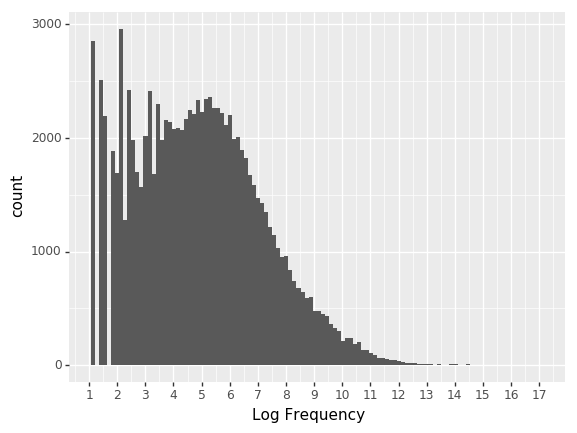

<ggplot: (8793697013519)>

In [36]:
ggplot(log_counts_df, aes(x="Counts")) + geom_histogram() + xlab('Log Frequency') + xlim(0.0,17.0) + scale_x_continuous(breaks=range(18))

There's relatively little mass to the left of `x = 2`. What's the corresponding frequency?

In [37]:
e ** 2

7.3890560989306495

≈7 counts. Let's check explore the effects of dropping entries with fewer than $k$ counts for various values of $k$:

In [38]:
K = tuple(map(int,
              (10000, 5000, 1000, 500, 100, 50, 10)))
for k in K:
    ws_below_count_threshold = {w for w in coca_freqs_aligned if coca_freqs_aligned[w] < k}
    num_Ws = len(ws_below_count_threshold)
    prop_of_total_Ws = num_Ws / len(alignable_orth_wordforms)
    remaining_Ws = len(alignable_orth_wordforms) - num_Ws
    
    sum_of_counts = sum(coca_freqs_aligned[w] for w in ws_below_count_threshold)
    prop_of_total_count = sum_of_counts / sum_of_aligned_counts
    
    print('For k = {0:,}\n\t{1:,} wordforms would be lost\n\t{2:,} wordforms would remain\n\t{3}% of the wordforms would be lost\n\t{4}% of the counts would be lost'.format(k, num_Ws, remaining_Ws, prop_of_total_Ws * 100, prop_of_total_count * 100))

For k = 10,000
	96,473 wordforms would be lost
	4,010 wordforms would remain
	96.00927520078024% of the wordforms would be lost
	14.666611975136872% of the counts would be lost
For k = 5,000
	93,741 wordforms would be lost
	6,742 wordforms would remain
	93.29040733258363% of the wordforms would be lost
	9.961912960846352% of the counts would be lost
For k = 1,000
	81,507 wordforms would be lost
	18,976 wordforms would remain
	81.11521351870465% of the wordforms would be lost
	3.355216754034295% of the counts would be lost
For k = 500
	72,745 wordforms would be lost
	27,738 wordforms would remain
	72.39533055342694% of the wordforms would be lost
	1.840204679536046% of the counts would be lost
For k = 100
	47,624 wordforms would be lost
	52,859 wordforms would remain
	47.39508175512276% of the wordforms would be lost
	0.34180872023204% of the counts would be lost
For k = 50
	37,152 wordforms would be lost
	63,331 wordforms would remain
	36.97341838918026% of the wordforms would be lost


It seems reasonable to have versions with the top 
 - 5k
 - 10k
 - 25k
 - 50k
 - 100k

wordforms.

In [39]:
lexicon = sorted(lexicon, 
                 key=lambda entry:entry['Frequency'], 
                 reverse = True)
lexicon[:5]
lexicon[-5:]

[{'Orthography': 'the', 'Transcription': 'ð.ʌ0', 'Frequency': 23801396},
 {'Orthography': 'and', 'Transcription': 'ʌ0.n.d', 'Frequency': 11675497},
 {'Orthography': 'of', 'Transcription': 'ʌ1.v', 'Frequency': 11337574},
 {'Orthography': 'to', 'Transcription': 't.u1', 'Frequency': 11079197},
 {'Orthography': 'a', 'Transcription': 'ʌ0', 'Frequency': 9738579}]

[{'Orthography': 'zofran', 'Transcription': 'z.oʊ1.f.ɹ.æ2.n', 'Frequency': 3},
 {'Orthography': 'zogg', 'Transcription': 'z.ɑ1.g', 'Frequency': 3},
 {'Orthography': 'zornes', 'Transcription': 'z.ɔ1.ɹ.n.z', 'Frequency': 3},
 {'Orthography': 'zuker', 'Transcription': 'z.u1.k.ɚ0', 'Frequency': 3},
 {'Orthography': 'zummo', 'Transcription': 'z.u1.m.oʊ0', 'Frequency': 3}]

In [40]:
N = tuple(map(int,
              (5e3, 1e4, 2.5e4, 5e4, 1e5)))
top = {n:lexicon[:n] for n in N}

# Applying the flapping rule / creating surface forms

The flapping rule (in the ARPABET and approximately representing stress as Gildea & Jurafsky do) is $$\text{t} \rightarrow \text{dx} / V' r^* \_\_ V$$.

Below I write code for enumerating each of the dotted strings (i.e. substrings in the CMU transcriptions) that matches the condition for applying the rule.

## Functions for manipulating transcriptions

In [41]:
ds2t = lambda ds: tuple(ds.split('.'))
t2ds = lambda ts: '.'.join(ts)

In [42]:
union = lambda Ss: reduce(set.union, Ss)

In [43]:
word_to_inv = lambda ds: set(ds2t(ds))
lex_to_inv = lambda Ws: union(map(word_to_inv,
                                   Ws))
get_transcription = lambda r: r['Transcription']
get_transcriptions = lambda L: list(map(get_transcription,
                                        L))

In [44]:
transcriptions = get_transcriptions(lexicon)

In [45]:
def dsToKfactors(k, ds):
    seq = ds2t(ds)
    l = len(seq)
    if k > l:
        return tuple()
    kFactor_start_indices = takewhile(lambda pair: pair[0] <= l-k, enumerate(seq))
    kFactors = tuple(seq[index[0]:index[0]+k] for index in kFactor_start_indices)
    return set(map(t2ds, kFactors))

def dsTo2factors(ds):
    return dsToKfactors(2, ds)

def dsTo3factors(ds):
    return dsToKfactors(3, ds)

def lexiconToKfactors(DSs, k):
    myDsToKfactors = lambda ds: dsToKfactors(k, ds)
    return union(map(set, map(myDsToKfactors, DSs)))

def lexiconTo2factors(DSs):
    return union(map(set, map(dsTo2factors, DSs)))

def lexiconTo3factors(DSs):
    return union(map(set, map(dsTo3factors, DSs)))

def compareKfactors(DSs_A, DSs_B, k):
    A = lexiconToKfactors(DSs_A, k)
    B = lexiconToKfactors(DSs_B, k)
    return {"A == B":A == B, "A - B": A - B, "B - A": B - A}

def sameKfactors(DSs_A, DSs_B, k):
    return compareKfactors(DSs_A, DSs_B, k)["A == B"]

def hasIllicitKfactors(W, illicit_k_factors):
    if type(W) == str:      
        # gather the k-factors into an immutable data structure
        illicit_kfs = tuple(illicit_k_factors)
        # get the set of k-factor lengths (values of k) among the illicit_kfs
        illicit_factor_lengths = set([len(ds2t(kf)) for kf in illicit_kfs])
        # map each k to the set of k-factors of dotted string ds
        kFactorSets = {kf_l:dsToKfactors(kf_l, W) for kf_l in illicit_factor_lengths}
        illegal_kfactors_discovered = tuple(ikf for ikf in illicit_kfs if ikf in kFactorSets[len(ds2t(ikf))])
        if illegal_kfactors_discovered == tuple():
            return False
        return illegal_kfactors_discovered
    else:
        myFunc = lambda w: hasIllicitKfactors(w, illicit_k_factors)
        results = tuple(map(myFunc, W))
        if not any(results):
            return False
        return set(t2ds(each) for each in results if each != False)

def dsToKfactorSequence(k, ds):
    seq = ds2t(ds)
    l = len(seq)
    if k > l:
        return tuple()
    kFactor_start_indices = takewhile(lambda pair: pair[0] <= l-k, enumerate(seq))
    kFactors = tuple(seq[index[0]:index[0]+k] for index in kFactor_start_indices)
    return tuple(map(t2ds, kFactors))

def threeFactorSequenceToDS(threeFactors):
    wLE = threeFactors[0][0]
    wRE = threeFactors[-1][-1]
    w_NE = '.'.join([ds2t(eachTriphone)[1] for eachTriphone in threeFactors])
    return '.'.join([wLE, w_NE, wRE])

## Carving up the inventory and defining symbol classes

In [46]:
inventory = lex_to_inv(transcriptions)
len(inventory)
inventory

69

{'aɪ0',
 'aɪ1',
 'aɪ2',
 'aʊ0',
 'aʊ1',
 'aʊ2',
 'b',
 'd',
 'dʒ',
 'eɪ0',
 'eɪ1',
 'eɪ2',
 'f',
 'g',
 'h',
 'i0',
 'i1',
 'i2',
 'j',
 'k',
 'l',
 'm',
 'n',
 'oʊ0',
 'oʊ1',
 'oʊ2',
 'p',
 's',
 't',
 'tʃ',
 'u0',
 'u1',
 'u2',
 'v',
 'w',
 'z',
 'æ0',
 'æ1',
 'æ2',
 'ð',
 'ŋ',
 'ɑ0',
 'ɑ1',
 'ɑ2',
 'ɔ0',
 'ɔ1',
 'ɔ2',
 'ɔɪ0',
 'ɔɪ1',
 'ɔɪ2',
 'ɚ0',
 'ɚ1',
 'ɚ2',
 'ɛ0',
 'ɛ1',
 'ɛ2',
 'ɪ0',
 'ɪ1',
 'ɪ2',
 'ɹ',
 'ʃ',
 'ʊ0',
 'ʊ1',
 'ʊ2',
 'ʌ0',
 'ʌ1',
 'ʌ2',
 'ʒ',
 'θ'}

In [47]:
vowels = {s for s in inventory if s[-1] in {'0', '1', '2'}}
len(vowels)
vowels

45

{'aɪ0',
 'aɪ1',
 'aɪ2',
 'aʊ0',
 'aʊ1',
 'aʊ2',
 'eɪ0',
 'eɪ1',
 'eɪ2',
 'i0',
 'i1',
 'i2',
 'oʊ0',
 'oʊ1',
 'oʊ2',
 'u0',
 'u1',
 'u2',
 'æ0',
 'æ1',
 'æ2',
 'ɑ0',
 'ɑ1',
 'ɑ2',
 'ɔ0',
 'ɔ1',
 'ɔ2',
 'ɔɪ0',
 'ɔɪ1',
 'ɔɪ2',
 'ɚ0',
 'ɚ1',
 'ɚ2',
 'ɛ0',
 'ɛ1',
 'ɛ2',
 'ɪ0',
 'ɪ1',
 'ɪ2',
 'ʊ0',
 'ʊ1',
 'ʊ2',
 'ʌ0',
 'ʌ1',
 'ʌ2'}

In [48]:
stressed_vowels = {v for v in vowels if v[-1] == '1' or v[-1] == '2'}
len(stressed_vowels)
stressed_vowels

30

{'aɪ1',
 'aɪ2',
 'aʊ1',
 'aʊ2',
 'eɪ1',
 'eɪ2',
 'i1',
 'i2',
 'oʊ1',
 'oʊ2',
 'u1',
 'u2',
 'æ1',
 'æ2',
 'ɑ1',
 'ɑ2',
 'ɔ1',
 'ɔ2',
 'ɔɪ1',
 'ɔɪ2',
 'ɚ1',
 'ɚ2',
 'ɛ1',
 'ɛ2',
 'ɪ1',
 'ɪ2',
 'ʊ1',
 'ʊ2',
 'ʌ1',
 'ʌ2'}

How many consecutive `ɹ`s are there actually in the transcriptions?

In [49]:
R = 'ɹ'
hasR = lambda ds: R in ds2t(ds)
hasRR = lambda ds: t2ds((R,R)) in ds2t(ds)
hasRRR = lambda ds: t2ds((R,R,R)) in ds2t(ds)

In [50]:
R_words = {1:list(filter(hasR, transcriptions)),
           2:list(filter(hasRR, transcriptions)),
           3:list(filter(hasRRR, transcriptions))}

In [51]:
len(R_words[1])
len(R_words[2])
len(R_words[3])

32213

0

0

At most 1.

In [52]:
zero_or_one_Rs = {'', R}

In [53]:
isNotEpsilon = lambda s: s != ''
removeEpsilon = lambda ts: tuple(filter(isNotEpsilon, 
                                        ts))
removeEpsilon(('i','','t','u'))

('i', 't', 'u')

Ok. Now we can enumerate all the LHSs for rules applying to strings of (stress-annotated) IPA symbols that together constitute a desugaring of the flapping rule...

In [54]:
LHSs = tuple(map(lambda ts: t2ds(removeEpsilon(ts)),
                 product(stressed_vowels, zero_or_one_Rs, 't', vowels)))
len(LHSs)
LHSs[:10]

2700

('ɑ1.t.ɑ1',
 'ɑ1.t.eɪ1',
 'ɑ1.t.ɔɪ0',
 'ɑ1.t.ɑ2',
 'ɑ1.t.aʊ2',
 'ɑ1.t.oʊ1',
 'ɑ1.t.u2',
 'ɑ1.t.ɪ0',
 'ɑ1.t.ɔɪ1',
 'ɑ1.t.ɑ0')

## Applying the flapping rule

In [55]:
flap = 'ɾ'
flap_substring_map = {lhs:lhs.replace('t', flap)
                      for lhs in LHSs}

def flappable(ds):
    return ds in LHSs

def has_flappable_substrings(ds):
    threeFactorSeq = dsToKfactorSequence(3, ds)
    return any(map(flappable,
                   threeFactorSeq))

def flappable_substrings(ds):
    if not has_flappable_substrings(ds):
        return tuple()
    threeFactorSeq = dsToKfactorSequence(3, ds)
    flappable3factors = tuple(filter(flappable,
                                     threeFactorSeq))
    return flappable3factors

def flap(ds_in):
    threeFactorSeq = dsToKfactorSequence(3, ds_in)
    flapped_3FS = tuple([flap_substring_map.get(f, f)
                         for f in threeFactorSeq])
    ds_out = threeFactorSequenceToDS(flapped_3FS)
    return ds_out

In [61]:
flappable_wordforms = {w for w in transcriptions if has_flappable_substrings(w)}
# flappable_wordforms = set(par(delayed(identity)(w) for w in transcriptions if has_flappable_substrings(w)))
len(flappable_wordforms)

5056

In [57]:
wordforms_with_multiple_flapping_opportunities = {w for w in flappable_wordforms if len(flappable_substrings(w)) > 1}
# wordforms_with_multiple_flapping_opportunities = set(par(delayed(identity)(w) 
#                                                          for w in flappable_wordforms 
#                                                          if len(flappable_substrings(w)) > 1))
len(wordforms_with_multiple_flapping_opportunities)
wordforms_with_multiple_flapping_opportunities

45

{'d.ɛ1.t.ʌ0.n.eɪ2.t.ɚ0',
 'd.ɛ1.t.ʌ0.n.eɪ2.t.ɚ0.z',
 'd.ɛ1.t.ʌ0.n.eɪ2.t.ɪ0.ŋ',
 'd.ɛ1.t.ʌ0.n.eɪ2.t.ʌ0.d',
 'k.æ2.t.ʌ0.l.ɪ1.t.ɪ0.k',
 'k.ɑ2.t.ɑ0.l.ɑ0.n.oʊ1.t.oʊ0',
 'k.ʌ0.m.p.j.u1.t.ɚ0.dʒ.ɛ1.n.ɚ0.eɪ2.t.ʌ0.d',
 'k.ʌ0.n.k.æ1.t.ʌ0.n.eɪ2.t.ɪ0.ŋ',
 'k.ʌ0.n.k.æ1.t.ʌ0.n.eɪ2.t.ʌ0.d',
 'l.ɪ1.t.ɪ0.g.eɪ2.t.ɪ0.d',
 'l.ɪ1.t.ɪ0.g.eɪ2.t.ɪ0.ŋ',
 'l.ɪ1.t.ʌ0.g.eɪ2.t.ɚ0',
 'l.ɪ1.t.ʌ0.g.eɪ2.t.ɚ0.z',
 'l.ɪ2.t.ɚ0.ɑ1.t.i0',
 'm.aɪ2.t.ɔ1.t.ɪ0.k',
 'm.i1.t.i2.t.ɪ0.ŋ',
 'm.j.u1.t.eɪ2.t.ɪ0.d',
 'm.j.u1.t.ʌ0.l.eɪ2.t.ɪ0.ŋ',
 'm.j.u1.t.ʌ0.l.eɪ2.t.ʌ0.d',
 'm.oʊ1.t.ʌ0.v.eɪ2.t.ɪ0.ŋ',
 'm.oʊ1.t.ʌ0.v.eɪ2.t.ʌ0.d',
 'm.ɪ1.t.ʌ0.g.eɪ2.t.ɪ0.d',
 'm.ɪ1.t.ʌ0.g.eɪ2.t.ɪ0.ŋ',
 'n.ɑ2.n.ɔ2.t.oʊ0.m.oʊ1.t.ɪ0.v',
 's.ɛ2.m.i0.ɔ2.t.ʌ0.m.æ1.t.ɪ0.k',
 't.i2.t.oʊ2.t.eɪ1.l.ɚ0',
 't.ɪ1.t.ʌ0.l.eɪ2.t.ɪ0.d',
 't.ɪ1.t.ʌ0.l.eɪ2.t.ɪ0.ŋ',
 'ɔ1.t.ʌ0.m.eɪ2.t.ɪ0.d',
 'ɔ1.t.ʌ0.m.eɪ2.t.ɪ0.ŋ',
 'ɔ2.t.ʌ0.k.ɹ.æ1.t.ɪ0.k',
 'ɔ2.t.ʌ0.m.oʊ1.t.ɪ0.v',
 'ɔ2.t.ʌ0.m.æ1.t.ɪ0.k',
 'ɔ2.t.ʌ0.m.æ1.t.ɪ0.k.l.i0',
 'ɔ2.t.ʌ0.m.æ1.t.ɪ0.k.s',
 'ɪ1.t.ɚ0.eɪ2.t.ɪ0.v',
 'ɪ2.t.i0.b

In [58]:
flappable_example_wordform = choice(list(flappable_wordforms))
flappable_example_wordform
flap(flappable_example_wordform)

's.ɛ1.t.ɪ0.ŋ.z'

's.ɛ1.ɾ.ɪ0.ŋ.z'

In [59]:
flappable_example_wordform2 = choice(list(wordforms_with_multiple_flapping_opportunities))
flappable_example_wordform2
flap(flappable_example_wordform2)

'm.j.u1.t.eɪ2.t.ɪ0.d'

'm.j.u1.ɾ.eɪ2.ɾ.ɪ0.d'

## Creating a list of positive input-output examples

In [70]:
positive_io_examples = [{'UR':w_in,
                         'SR':flap(w_in)}
                        for w_in in flappable_wordforms]
len(positive_io_examples)
list(positive_io_examples)[:10]

5056

[{'UR': 'ɹ.aɪ1.t.ɪ0.s.t.s', 'SR': 'ɹ.aɪ1.ɾ.ɪ0.s.t.s'},
 {'UR': 'p.æ1.t.ʌ0.n.t.ʌ0.b.ʌ0.l', 'SR': 'p.æ1.ɾ.ʌ0.n.t.ʌ0.b.ʌ0.l'},
 {'UR': 'oʊ2.v.ɚ0.ɹ.eɪ1.t.ɪ0.d', 'SR': 'o.v.ɚ0.ɹ.eɪ1.ɾ.ɪ0.d'},
 {'UR': 'l.ɑ0.k.oʊ1.t.ʌ0.z', 'SR': 'l.ɑ0.k.oʊ1.ɾ.ʌ0.z'},
 {'UR': 'ɹ.i1.t.eɪ2.l.ɚ0.z', 'SR': 'ɹ.i1.ɾ.eɪ2.l.ɚ0.z'},
 {'UR': 'æ1.n.t.ʌ0.k.w.eɪ2.t.ʌ0.d', 'SR': 'æ.n.t.ʌ0.k.w.eɪ2.ɾ.ʌ0.d'},
 {'UR': 'k.ʌ1.l.m.ʌ0.n.eɪ2.t.ʌ0.d', 'SR': 'k.ʌ1.l.m.ʌ0.n.eɪ2.ɾ.ʌ0.d'},
 {'UR': 'ʌ0.s.ɛ1.t.ʌ0.l.i2.n', 'SR': 'ʌ.s.ɛ1.ɾ.ʌ0.l.i2.n'},
 {'UR': 'k.w.ɑ1.l.ʌ0.t.eɪ2.t.ɪ0.v', 'SR': 'k.w.ɑ1.l.ʌ0.t.eɪ2.ɾ.ɪ0.v'},
 {'UR': 'æ1.t.ɚ0.b.ɛ0.ɹ.i0', 'SR': 'æ.ɾ.ɚ0.b.ɛ0.ɹ.0'}]

In [67]:
positive_io_example_fn = 'positive_flapping_io_examples.tsv'

In [77]:
?csv.DictWriter

In [72]:
with open(positive_io_example_fn, 'w') as file:
    writer = csv.DictWriter(file, ['UR','SR'], delimiter='\t')
    for ex in positive_io_examples:
        writer.writerow(ex)

35

49

43

37

37

50

51

40

51

35

29

35

28

30

48

57

51

51

20

49

29

51

20

25

54

43

59

33

44

51

47

20

40

24

37

50

39

29

25

44

43

30

49

29

33

28

31

51

25

31

34

45

42

20

42

34

69

46

27

54

26

59

32

38

35

53

33

32

36

70

53

25

31

40

29

46

31

55

25

22

40

40

61

20

46

47

49

42

35

31

57

41

25

51

35

27

37

46

43

51

25

45

48

42

30

35

35

31

50

42

39

33

40

25

31

20

55

37

29

43

25

54

32

21

37

54

38

34

46

42

48

44

16

33

26

25

43

25

44

25

25

33

27

45

47

44

61

39

34

35

54

33

35

57

40

41

25

40

44

27

25

29

39

44

39

45

56

39

39

33

49

61

37

28

34

39

48

47

20

44

41

34

23

45

40

21

30

39

53

31

43

25

37

31

53

40

42

43

43

55

31

20

43

52

25

29

30

35

55

51

21

51

45

38

49

47

30

41

35

30

46

55

30

35

21

45

24

36

37

45

52

34

35

29

24

27

30

44

40

37

36

25

33

25

61

41

39

20

43

27

26

57

45

46

25

24

45

29

39

31

43

51

43

27

39

38

46

39

25

48

61

53

29

25

35

53

40

25

39

54

25

43

27

31

42

42

30

61

25

54

33

63

45

24

25

34

35

27

48

20

21

49

25

25

36

29

27

30

32

37

49

71

37

47

46

47

29

29

51

39

25

30

31

21

40

55

20

42

26

25

27

35

37

45

20

52

30

31

40

39

24

53

21

61

47

39

38

54

25

43

51

25

43

59

35

16

29

47

26

27

39

35

56

42

39

49

56

25

30

31

47

44

60

31

26

45

20

37

42

51

51

43

20

24

50

37

39

48

24

43

20

26

25

64

24

27

63

42

46

56

20

40

37

49

26

34

24

37

51

44

27

39

31

48

24

27

27

43

44

25

20

38

58

25

29

52

27

53

59

41

56

30

51

35

24

35

63

41

31

45

35

30

27

29

49

25

29

36

20

30

29

20

35

39

51

41

23

62

35

46

45

35

30

29

41

48

60

27

20

29

29

25

27

37

31

25

39

31

25

44

30

30

20

56

48

36

34

40

29

44

47

53

46

31

46

33

56

37

56

41

35

35

57

25

35

29

29

26

34

35

71

31

26

21

39

51

32

27

49

41

20

37

34

52

35

41

21

60

57

25

39

34

42

24

39

27

63

37

27

20

29

55

51

40

39

57

25

31

30

49

56

30

39

43

31

32

25

40

39

45

25

26

53

26

20

37

30

31

64

29

59

22

47

42

31

27

22

45

41

20

29

41

47

29

59

41

49

43

23

20

32

43

35

33

35

27

39

43

32

44

25

34

57

27

41

58

56

32

35

25

49

35

43

52

47

29

53

31

35

65

64

43

62

33

43

35

47

41

41

30

62

27

25

52

33

27

39

37

34

35

31

25

50

49

57

20

34

24

24

41

29

33

55

28

39

43

35

39

35

39

30

48

31

25

34

29

36

40

43

20

31

52

52

38

42

54

25

39

34

20

36

21

46

35

34

30

39

47

27

25

49

67

43

51

25

38

45

29

20

29

39

48

27

56

27

66

40

30

25

48

50

56

36

28

20

41

38

42

30

47

39

20

54

53

58

25

37

31

39

31

53

31

51

51

31

35

59

30

51

46

33

31

37

27

53

47

38

58

48

29

50

33

29

39

39

30

39

21

35

47

20

51

45

36

39

41

31

16

29

29

35

34

29

24

51

43

20

39

60

36

29

16

34

35

39

61

33

43

27

25

33

25

39

39

57

37

37

49

53

27

29

45

20

53

46

35

41

37

25

50

47

39

58

25

52

22

51

56

49

46

29

38

39

34

20

69

41

20

20

41

22

31

43

21

20

59

30

43

37

43

54

29

41

57

20

59

34

29

38

34

49

25

31

52

29

53

25

35

38

42

57

25

43

47

50

35

20

47

33

31

25

39

43

25

37

58

37

29

51

40

47

29

52

25

45

31

25

25

37

31

31

30

31

34

51

63

21

21

45

50

30

15

61

26

45

37

46

35

20

51

39

39

40

20

25

29

35

29

37

20

31

59

25

39

41

34

52

31

63

50

45

37

57

25

63

58

33

46

73

26

37

46

20

33

20

56

30

35

47

55

45

20

29

45

48

61

41

34

29

42

25

35

47

54

32

20

49

30

56

53

35

57

50

50

27

39

34

35

20

30

22

30

30

43

43

30

55

16

25

37

39

35

25

52

56

24

25

45

45

20

49

39

36

50

30

50

20

38

25

43

26

24

39

25

43

23

47

25

51

41

26

31

37

39

34

30

34

20

51

34

22

39

39

27

37

39

31

38

51

24

39

50

20

29

29

59

57

47

25

61

34

53

45

30

60

25

55

59

51

29

30

33

50

65

25

55

27

35

32

39

57

39

47

48

41

21

31

39

25

53

45

24

27

73

31

51

41

34

48

20

40

22

50

45

32

31

25

61

43

37

47

29

32

40

42

25

25

25

59

48

29

37

61

31

54

46

52

32

55

78

27

44

39

45

20

45

31

47

42

56

44

56

58

43

20

32

29

52

46

35

30

27

25

39

43

38

20

26

55

69

45

45

20

51

25

20

31

33

53

40

39

41

24

51

51

49

25

26

35

53

20

41

26

35

21

41

22

53

69

53

26

33

36

50

44

67

34

42

35

44

27

25

64

25

24

35

20

24

25

33

38

47

47

29

50

26

42

46

40

30

25

26

33

29

47

64

46

55

35

31

51

15

30

32

22

26

57

30

27

27

49

41

35

40

36

33

36

62

63

51

39

41

56

31

35

20

28

25

47

52

53

43

30

53

46

47

45

41

29

47

34

27

57

43

26

36

47

45

25

20

56

41

45

36

59

57

22

25

39

44

60

38

51

41

57

25

42

45

30

49

25

50

39

25

49

63

64

27

43

34

55

59

38

26

20

40

26

45

35

63

25

39

21

51

52

43

47

47

25

25

32

50

29

57

49

48

25

33

22

49

43

43

43

31

20

31

47

39

51

30

55

26

45

16

58

39

30

46

41

31

36

44

32

52

25

48

39

34

43

33

35

34

51

36

47

42

31

61

20

46

43

31

42

29

20

54

41

27

37

43

39

48

28

46

55

34

39

37

31

35

20

52

47

25

55

42

46

35

31

65

36

44

30

27

44

43

25

52

30

56

24

30

25

27

73

65

37

33

60

49

39

36

58

31

25

39

46

49

46

39

27

25

36

51

24

39

41

44

42

49

29

29

29

73

47

57

30

29

40

30

39

37

37

24

48

34

20

51

45

56

38

47

25

25

40

25

44

25

41

51

41

47

48

30

51

60

54

29

20

26

33

58

41

43

31

25

38

20

25

35

31

53

21

36

29

48

24

30

25

50

51

27

25

53

58

36

29

52

60

42

29

25

46

21

72

45

56

53

26

42

40

27

25

27

27

28

57

25

47

25

29

46

39

54

36

53

40

20

27

29

59

29

47

30

51

39

33

25

25

69

65

25

20

69

41

39

41

25

51

30

25

31

37

30

61

20

30

34

50

41

24

51

41

25

43

24

53

29

37

43

45

43

29

61

27

25

30

25

63

31

34

25

35

46

26

31

21

25

46

27

20

46

20

43

24

43

47

45

35

20

45

31

25

40

31

53

35

38

66

34

61

35

24

39

48

30

46

33

31

30

20

33

45

31

48

34

39

51

32

27

30

29

30

47

26

35

60

20

38

52

56

53

50

55

51

43

44

36

37

27

21

41

59

31

55

57

53

42

34

36

35

42

29

22

29

52

22

22

33

43

52

41

27

29

36

52

40

29

20

48

44

27

43

35

37

29

30

49

39

40

65

27

33

20

29

21

35

52

39

83

29

39

55

31

58

45

25

27

29

25

53

38

15

45

41

49

31

35

47

53

43

61

33

52

57

22

45

52

35

25

35

31

59

36

30

29

38

25

42

26

43

39

43

25

49

27

40

21

60

45

60

35

26

22

35

26

25

31

26

51

27

30

57

49

44

35

39

51

44

27

27

23

30

39

40

25

20

56

30

20

62

55

35

41

25

42

34

41

52

63

35

51

36

34

43

25

31

31

59

27

35

34

35

39

35

50

34

50

27

32

30

45

49

30

37

35

41

46

35

55

20

37

51

34

55

30

47

56

47

30

64

44

20

48

22

61

24

40

38

46

41

20

46

45

25

29

67

44

41

47

37

25

33

26

46

41

41

53

43

53

29

49

67

35

50

49

63

39

35

35

35

45

26

52

45

31

40

53

41

26

25

25

25

43

46

45

20

39

29

59

29

30

22

49

46

33

41

27

45

41

36

59

43

30

38

34

41

73

25

41

42

45

40

53

41

32

61

22

45

59

36

58

27

25

30

23

38

43

29

35

26

36

41

62

35

39

26

41

27

39

35

51

25

51

26

20

51

56

43

31

29

46

56

53

36

24

61

39

52

37

61

29

35

53

22

35

59

25

39

29

31

47

53

52

39

29

40

32

47

39

40

29

29

54

61

43

41

49

61

42

45

35

47

51

25

56

36

35

47

56

57

20

39

29

61

30

29

35

20

30

34

31

35

31

15

61

20

37

45

35

36

35

29

41

29

21

25

53

26

36

47

39

41

44

43

40

59

33

39

32

44

51

58

43

65

37

45

26

49

54

35

39

47

26

41

27

47

58

32

42

25

38

22

25

40

20

31

51

24

35

20

57

25

54

31

43

43

34

44

31

25

30

29

27

49

39

40

49

67

43

21

64

58

45

51

68

37

39

33

65

39

38

25

27

55

69

25

20

26

43

35

36

43

24

20

41

43

34

30

31

31

48

41

32

47

34

32

25

59

20

27

39

39

55

25

35

45

25

51

29

29

29

24

21

43

25

24

46

29

21

36

34

74

46

50

22

33

55

31

58

23

45

35

49

25

27

25

43

51

49

36

32

33

34

63

20

25

41

31

34

28

37

41

55

30

36

30

20

16

20

25

38

39

53

29

27

29

20

43

36

42

39

51

20

70

25

39

35

39

29

65

47

33

39

65

26

27

57

50

51

28

61

25

38

34

56

43

43

43

42

30

39

37

41

25

50

49

51

45

45

46

20

35

39

29

54

39

31

44

62

50

36

20

37

45

67

43

42

30

29

34

26

25

20

45

61

26

57

33

25

29

25

30

53

44

26

29

42

45

22

24

32

33

55

35

36

29

58

34

27

45

34

20

52

47

37

22

30

30

35

36

20

30

47

52

39

21

27

39

56

15

35

25

35

43

45

25

25

25

25

20

20

45

39

54

35

55

25

30

35

25

30

25

26

39

31

26

49

44

25

45

47

24

49

44

27

44

56

26

52

35

45

57

38

26

27

31

39

55

39

39

74

32

45

53

71

44

30

39

37

36

26

20

22

39

50

26

25

37

64

35

39

30

36

24

29

60

34

25

20

39

25

20

27

42

49

27

47

54

60

31

30

39

39

38

46

54

20

39

28

20

20

48

15

45

43

40

31

41

38

35

25

59

51

39

35

44

39

27

48

47

30

31

36

45

29

54

43

41

58

49

41

54

56

26

44

25

37

37

37

43

37

21

46

25

53

23

26

56

41

46

44

32

37

31

46

45

34

35

53

35

29

26

25

57

20

43

49

40

37

38

29

53

26

20

39

25

35

31

35

45

48

35

43

47

48

39

41

26

33

44

39

20

29

35

29

28

31

25

50

34

25

25

61

32

53

39

43

32

36

26

37

35

52

74

31

47

65

39

45

43

35

35

41

37

20

41

42

37

43

38

55

38

20

25

25

32

35

43

25

63

49

27

31

43

45

40

24

39

43

35

40

57

30

38

43

30

60

65

59

32

31

37

47

30

57

47

20

43

34

22

25

57

35

20

41

25

25

32

39

30

47

20

39

69

31

50

27

29

49

30

42

30

27

53

32

51

31

46

48

34

37

41

49

35

56

25

30

51

39

25

43

21

20

29

41

35

27

20

47

40

42

25

35

25

39

31

30

51

48

42

62

39

46

30

45

40

37

29

57

39

27

48

42

57

40

32

43

57

21

37

31

59

47

49

50

21

50

50

27

47

47

40

45

52

29

51

53

43

57

55

22

43

45

45

43

46

20

27

49

41

51

40

26

16

49

25

43

51

49

49

53

43

59

29

27

35

36

25

31

25

43

39

41

24

25

50

37

59

51

43

21

61

24

56

29

21

29

55

36

45

34

31

54

46

47

55

53

25

35

39

41

32

29

31

63

24

29

40

20

35

37

36

39

52

35

25

58

47

25

39

25

41

37

27

29

24

37

47

31

34

35

20

43

51

53

20

46

37

32

33

31

25

25

49

38

37

50

25

43

56

39

35

39

27

49

47

37

67

34

26

35

39

43

41

53

22

51

33

29

38

25

25

41

38

48

66

43

56

47

38

50

51

31

24

60

63

25

35

48

63

20

20

53

35

20

25

50

29

67

56

47

32

32

25

38

52

20

25

42

54

20

42

45

41

33

55

35

37

27

29

25

35

20

25

43

30

27

35

41

35

67

25

56

25

25

51

48

35

25

30

37

46

42

39

57

43

48

39

25

15

36

34

51

27

30

22

47

30

28

61

54

41

44

42

55

25

48

63

29

25

31

33

15

33

24

28

41

34

39

51

30

27

45

29

40

41

35

27

61

25

27

31

31

31

43

50

21

53

38

37

29

43

29

65

32

27

25

40

27

20

22

55

24

34

37

22

37

61

27

51

47

34

47

30

40

47

41

31

47

50

27

47

38

34

61

39

64

22

30

42

64

32

24

34

37

30

24

39

30

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



40

26

31

44

55

29

25

45

37

29

33

31

25

25

36

30

25

32

39

25

25

48

43

35

27

33

39

34

60

39

25

67

31

36

29

24

47

45

45

29

25

25

56

37

43

47

39

26

50

25

29

37

31

40

47

31

44

32

29

47

51

31

43

47

33

29

51

60

27

25

30

32

57

53

42

21

51

31

60

61

27

39

53

35

51

55

22

29

36

61

25

20

29

41

41

53

37

47

36

25

27

43

29

42

22

61

31

30

35

22

53

25

27

39

37

40

57

25

47

31

27

23

39

48

28

34

22

27

58

49

36

32

41

25

39

59

21

31

45

46

52

22

51

59

22

25

69

44

47

42

37

38

31

28

61

20

46

27

31

27

57

35

41

24

47

20

43

20

47

24

31

22

42

27

In [76]:
%cat -n /mnt/cube/home/AD/emeinhar/gj-flap-data/positive_flapping_io_examples.tsv | head -60





























































cat: write error: Broken pipe


In [71]:
?csv.DictWriter.writerow